In [68]:
#utils
import numpy as np
import pandas as pd
import time

import scipy
def split_data(X, Y, training_percentage):
    N= X.shape[0]

    idx = np.arange(N)
    np.random.shuffle(idx)
    train_idx = idx[:int(N*training_percentage)]
    test_idx = idx[int(N*training_percentage):]

    X_train = X[train_idx]
    y_train = Y[train_idx]
    
    X_test = X[test_idx]
    y_test = Y[test_idx]

    return (X_train, y_train), (X_test, y_test)

def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs,lamb=None):
    X,y=D
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch,lamb)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y,lamb)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history
def backtracking(f, grad_f, x,X,y,lamb=None):
    alpha = 1
    c = 0.8
    tau = 0.25
    min_alpha = 1e-20  # Safety lower bound for alpha

    while f(x - alpha * grad_f(x, X, y, lamb), X, y, lamb) > f(x, X, y, lamb) - c * alpha * np.linalg.norm(grad_f(x, X, y, lamb), 2) ** 2:
        alpha *= tau
        if alpha < min_alpha:
            raise ValueError("Backtracking line search failed: step size too small.")
    return alpha

def GD(loss, grad_f, theta0, alpha, X, y, maxit=100, tolf=1e-5, tolx=1e-5, lamb=None):
    # Initialize the infos
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))
    theta_history = []

    # Set the values of the infos for theta0
    f_val[0] = loss(theta0, X, y, lamb)  # Store the initial loss
    grad_norm[0] = np.linalg.norm(grad_f(theta0, X, y, lamb))
    theta_history.append(theta0.copy())

    # Kernel of the code:
    # Implement the for loop for the update of theta
    for k in range(maxit):
        # Compute alpha
        #alpha = backtracking(loss, grad_f, theta0, X, y, lamb)

        theta = theta0 - alpha * grad_f(theta0, X, y, lamb)
        theta_history.append(theta)
        # Update the info
        f_val[k+1] = loss(theta, X, y, lamb)
        grad_norm[k+1] = np.linalg.norm(grad_f(theta, X, y, lamb))

        # Stopping criteria
        if np.linalg.norm(grad_f(theta, X, y, lamb)) <= tolf * grad_norm[0] or np.linalg.norm(theta - theta0) < tolx:
            break

        # Update of theta0
        theta0 = theta

    # Cut off the exceeding values
    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]

    return theta, k, f_val, grad_norm, theta_history


def f(theta,x):
    k = len(theta)
    return np.flip(np.vander(x,k), 1) @ theta


def MLE_loss(theta, X, y,lamb=None):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K 
    return (np.linalg.norm(Phi_X @ theta - y)**2)/2

def MLE_grad_loss(theta, X, Y,lamb=None):
    Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K
    return Phi_X.T @ ((Phi_X @ theta) - Y)

def MAP_loss(theta, X, Y, lam):
    Phi_X = Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K 
    return (np.linalg.norm(Phi_X @ theta - Y)**2 + lam * np.linalg.norm(theta) ** 2)/2 

def MAP_grad_loss(theta, X, Y, lam):
    Phi_X = Phi_X = np.flip(np.vander(X,len(theta)), 1) # N x K
    return Phi_X.T @ (Phi_X @ theta - Y) + lam * theta

def normal_eq_cholesky(X, y, K):
 # Construct the Vandermonde matrix for polynomial features
    Phi_X = np.flip(np.vander(X,K), 1)

    # Compute Phi_X^T * Phi_X
    A = Phi_X.T @ Phi_X
    
    # Perform Cholesky decomposition
    L = np.linalg.cholesky(A)
    
    # Solve the first system L * z = Phi_X.T @ y
    z = scipy.linalg.solve_triangular(L, Phi_X.T @ y, lower=True)
    
    # Solve the second system L^T * theta = z
    theta = scipy.linalg.solve_triangular(L.T, z, lower=False)
    
    return theta

def normal_eq_cholesky_MAP(X, y, K, l):
    # Construct the Vandermonde matrix for polynomial features
    Phi_X = np.flip(np.vander(X, K), 1)  # N x K
    
    # Compute the regularized matrix A = Phi_X.T @ Phi_X + l * I
    A = Phi_X.T @ Phi_X + l * np.identity(K)
    
    # Perform Cholesky decomposition: A = L L^T
    L = np.linalg.cholesky(A)
    
    # Solve the first system Lz = Phi_X.T @ y (forward substitution)
    z = scipy.linalg.solve_triangular(L, Phi_X.T @ y, lower=True)
    
    # Solve the second system L^T theta = z (backward substitution)
    theta = scipy.linalg.solve_triangular(L.T, z, lower=False)
    
    return theta

def compute_error(theta, test_set):
    X_test, Y_test = test_set
    return 1/len(Y_test) * np.linalg.norm(f(theta, X_test) - Y_test,2)**2#return (1 / len(Y_test)) * np.sum((f(theta, X_test) - Y_test) ** 2)

This formula here gives us the gradient of the loss function for MLE:
$$
    \begin{cases}
        \theta_0 \in \mathbb{R}^K \\
        \theta_{k+1} = \theta_k - \alpha_k \nabla_{\theta} (- \log p_{\theta_k}(y|x)) = \theta_k - \alpha_k \Phi(X)^T (\Phi(X) \theta - Y).
    \end{cases}
$$
which is:
$$\Phi(X)^T (\Phi(X) \theta - Y).$$

## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Consider the theory and the notation provided in the the MLE/MAP section (https://devangelista2.github.io/statistical-mathematical-methods/regression_classification/MLE_MAP.html). Let $f_\theta(x)$ be a polynomial regression model as in the previous Homework, and let the `poly_regression_small.csv` from Virtuale be the training set. Then, sample 20% of the data in the `poly_regression_large.csv` dataset to use as test set.


In [69]:
#Load the dataset
data1 = pd.read_csv('poly_regression_large.csv')
X, Y = data1["x"], data1["y"]
X=np.array(X)
Y=np.array(Y)

(_, _), (X_test, y_test) = split_data(X, Y, 0.80)
data2 = pd.read_csv('poly_regression_small.csv')
X_train, Y_train = data2["x"], data2["y"]
print(X_test.shape)


(200,)



* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.

In [70]:
def GD_MLE(X, y, K, alpha, maxit=100, tolf=1e-8, tolx=1e-8):
    # Initialize theta with random values
    theta0 = np.zeros(K)

    # Run your GD function with the provided loss and gradient functions
    theta, iterations, loss_history, grad_norm_history, _ = GD(
        MLE_loss, MLE_grad_loss, theta0, alpha, X, y, maxit, tolf, tolx,
    )
    
    return theta, loss_history, grad_norm_history
    
def SGD_MLE(X, y, K, alpha, batch_size, n_epochs):
    # Initialize theta with random values
    theta0 = np.zeros(K)

    # Prepare data tuple for SGD
    D = (X, y)

    # Run your SGD function with the provided loss and gradient functions
    theta_history, loss_history, grad_norm_history = SGD(
        MLE_loss, MLE_grad_loss, D, theta0, alpha, batch_size, n_epochs
    )
    
    # Return the final theta and histories
    final_theta = theta_history[-1]
    return final_theta, loss_history, grad_norm_history

def NE_MLE(X, y, K):
    # Solve for theta using your normal_eq_cholesky function
    theta = normal_eq_cholesky(X, y, K)
    return theta

* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 
* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.

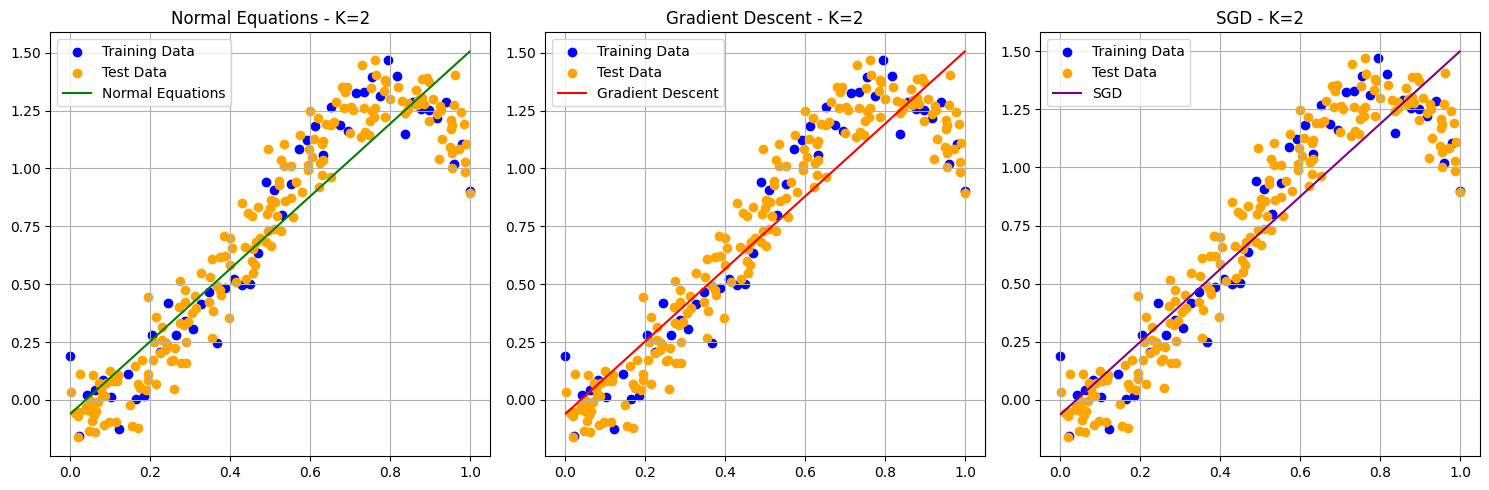

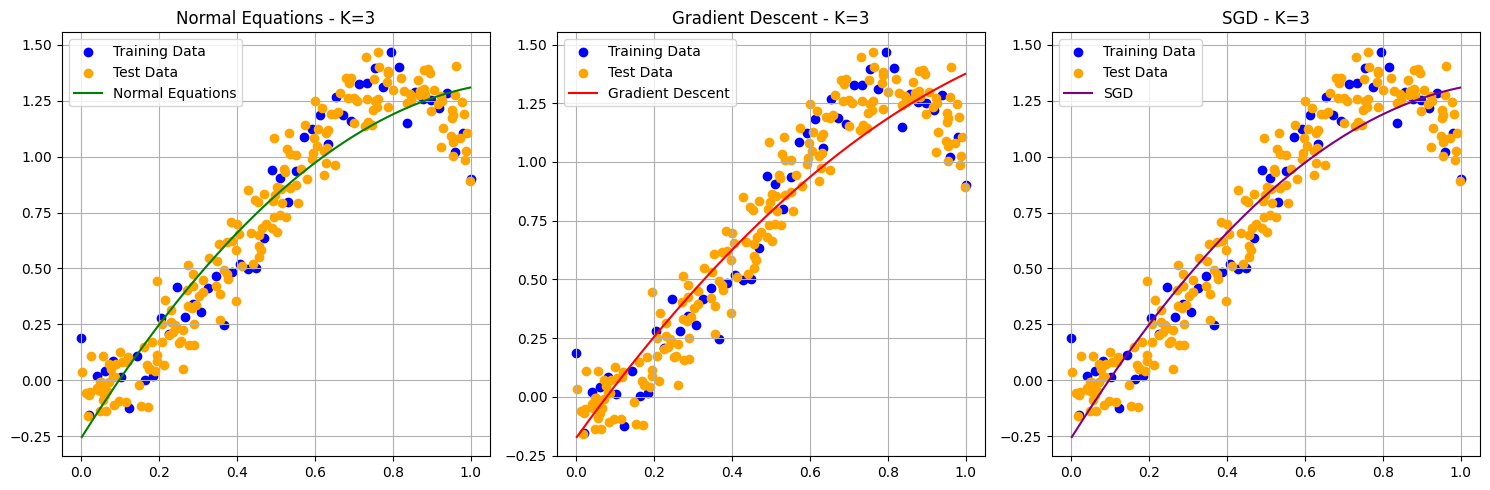

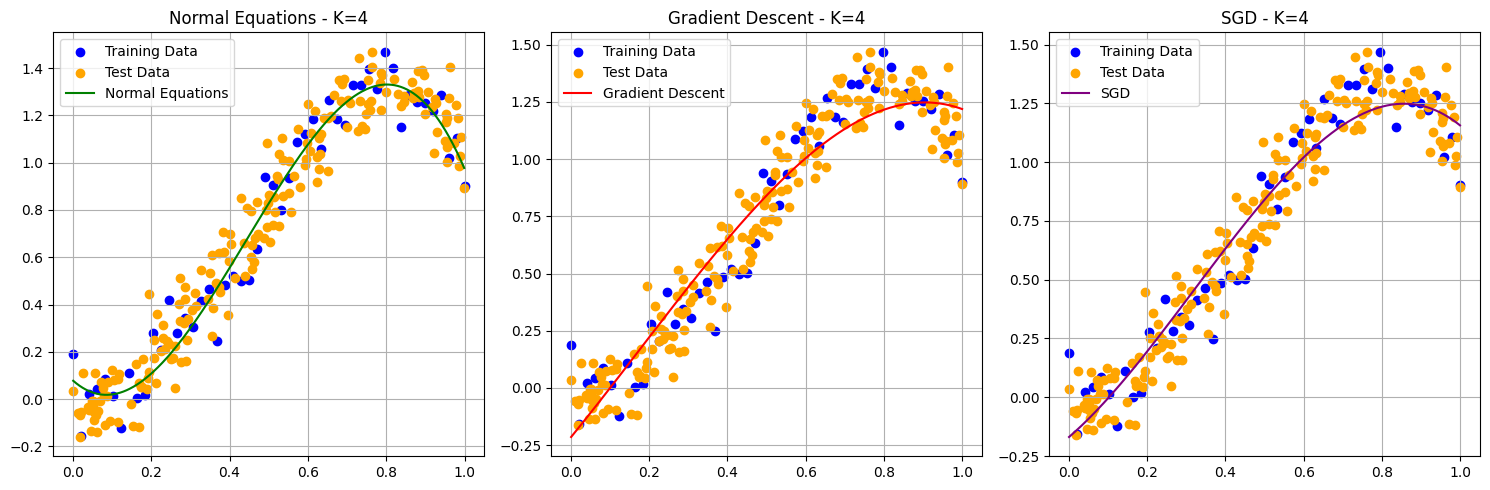

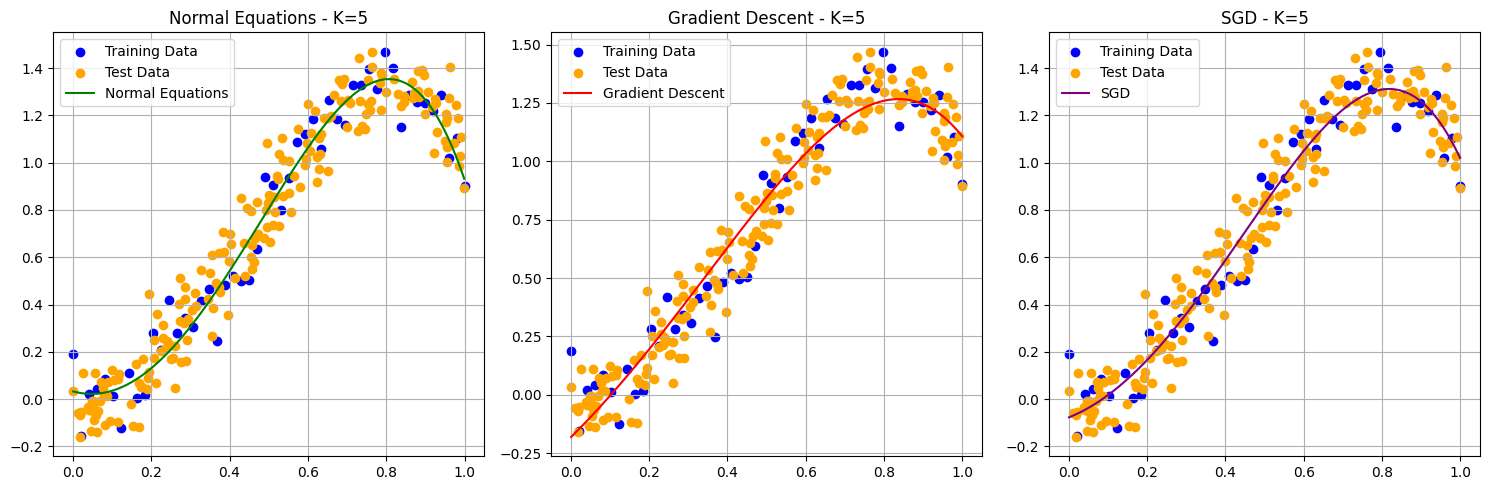

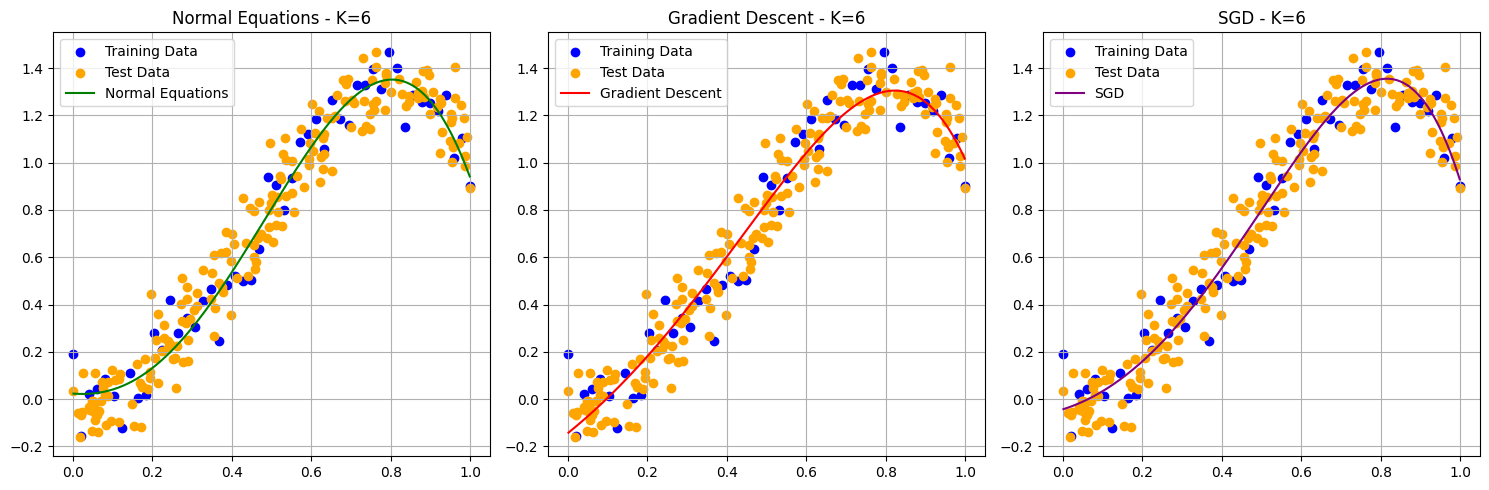

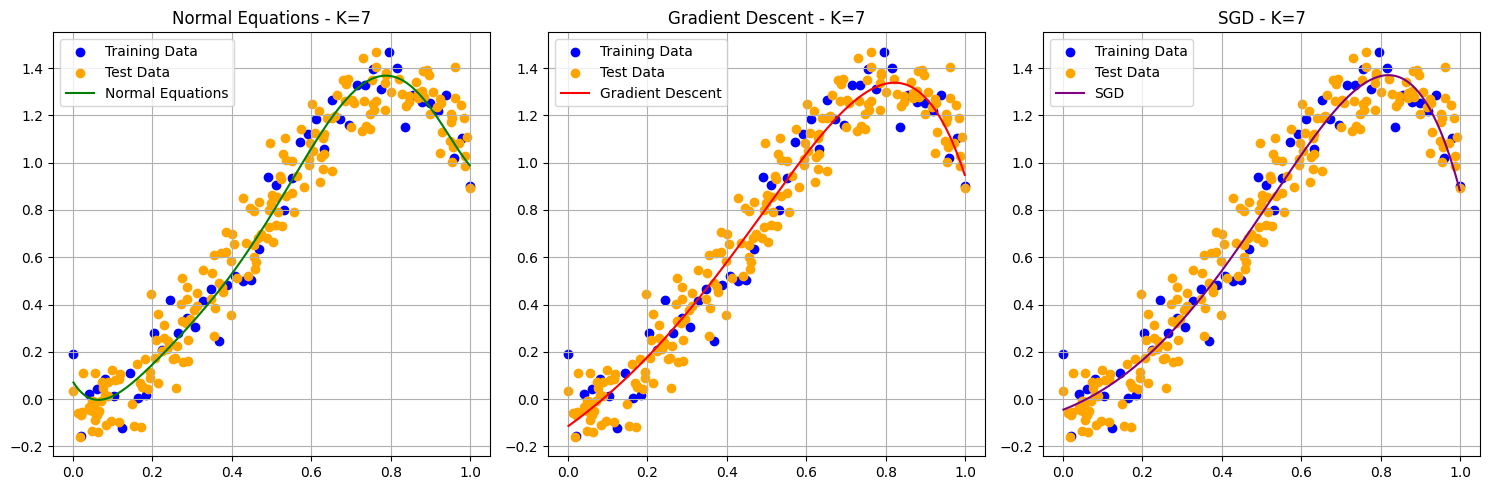

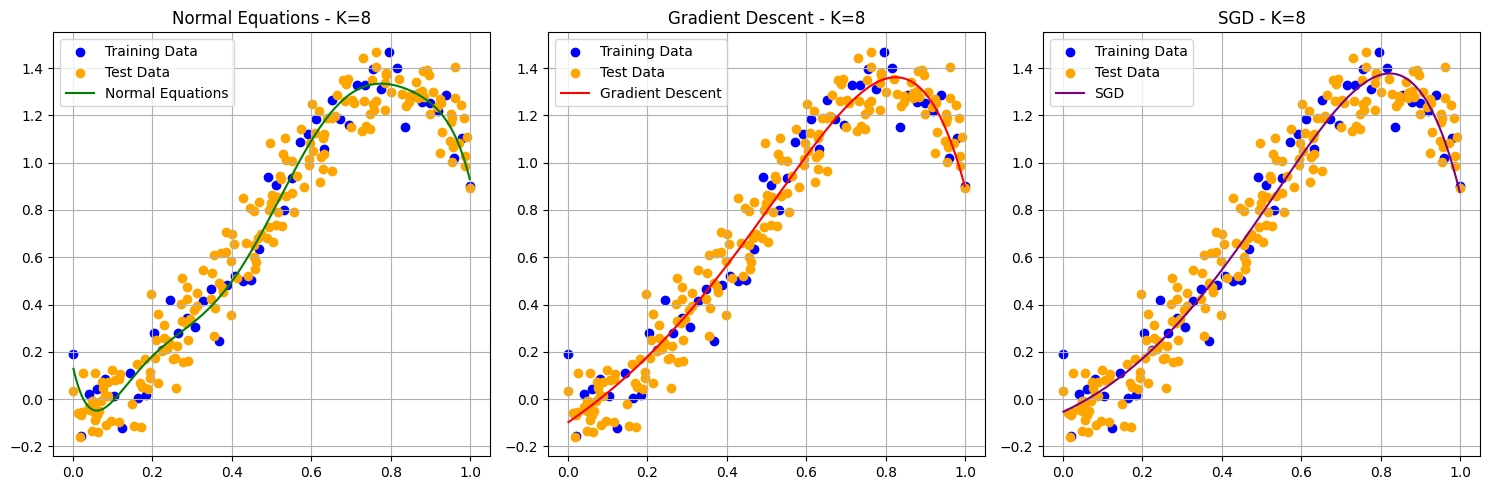

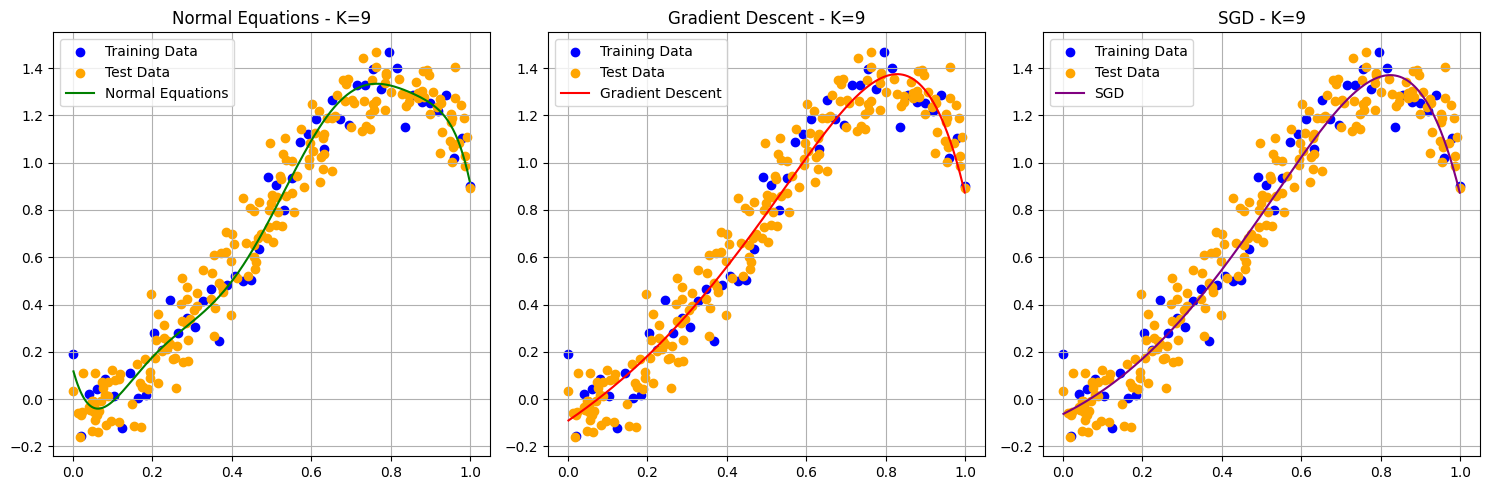

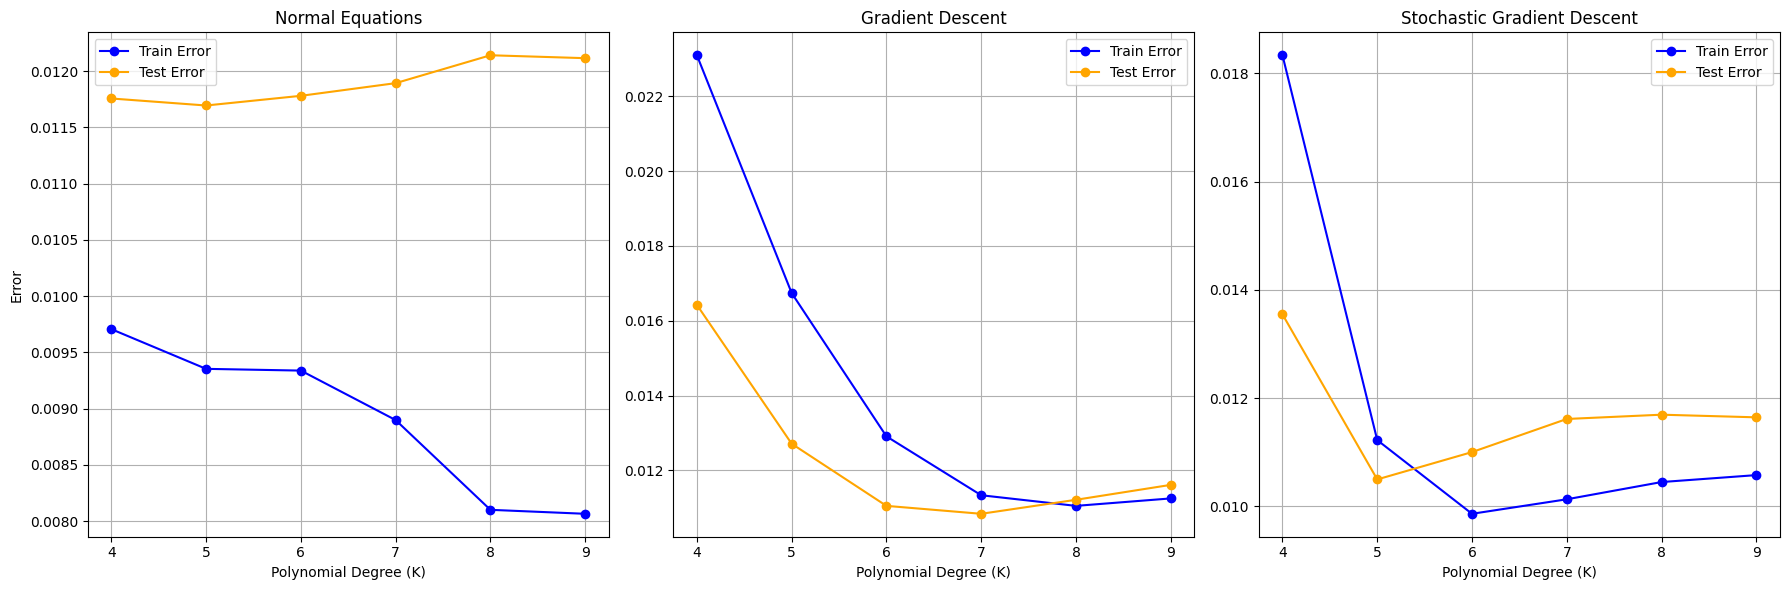

In [71]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
train_errors_ne = []
KKs=[]
test_errors_ne = []
train_errors_gd = []
test_errors_gd = []
train_errors_sgd = []
test_errors_sgd = []
thetas_gd=[]
thetas_sgd=[]
thetas_ne=[]
alpha_SGD = 0.01
alpha_GD=0.01
batch_size = 5
n_epochs =5000
maxit = 1000
tolf = 1e-5
tolx = 1e-5

for K in range(2,10):
    KKs.append(K)
    # Normal Equations
    start_time = time.time()
    theta_ne = NE_MLE(X_train, Y_train, K)
    time_ne = time.time() - start_time
    thetas_ne.append(theta_ne)
    train_error_ne = compute_error(theta_ne, (X_train, Y_train))
    test_error_ne = compute_error(theta_ne, (X_test, y_test))
    train_errors_ne.append(train_error_ne)
    test_errors_ne.append(test_error_ne)
    # Gradient Descent
    start_time = time.time()
    theta_gd, loss_hist_gd, grad_norm_hist_gd = GD_MLE(X_train, Y_train, K, alpha_GD, maxit, tolf, tolx)
    time_gd = time.time() - start_time
    thetas_gd.append(theta_gd)
    train_error_gd = compute_error(theta_gd, (X_train, Y_train))
    test_error_gd = compute_error(theta_gd, (X_test, y_test))
    train_errors_gd.append(train_error_gd)
    test_errors_gd.append(test_error_gd)

    # Stochastic Gradient Descent
    start_time = time.time()
    theta_sgd, loss_hist_sgd, grad_norm_hist_sgd = SGD_MLE(X_train, Y_train, K, alpha_SGD, batch_size, n_epochs)
    time_sgd = time.time() - start_time
    thetas_sgd.append(theta_sgd)
    train_error_sgd = compute_error(theta_sgd, (X_train, Y_train))
    test_error_sgd = compute_error(theta_sgd, (X_test, y_test))
    train_errors_sgd.append(train_error_sgd)
    test_errors_sgd.append(test_error_sgd)

    # Prepare x_range for plotting
    x_range = np.linspace(min(X_test), max(X_test), 500)
    y_ne = f( theta_ne,x_range)
    y_gd = f(theta_gd,x_range)
    y_sgd = f(theta_sgd,x_range)

    # Create a figure with 3 subplots side by side for each K
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[0].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[0].plot(x_range, y_ne, label="Normal Equations", color="green")
    axes[0].set_title(f'Normal Equations - K={K}')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[1].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[1].plot(x_range, y_gd, label="Gradient Descent", color="red")
    axes[1].set_title(f'Gradient Descent - K={K}')
    axes[1].legend()
    axes[1].grid(True)
    
    axes[2].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[2].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[2].plot(x_range, y_sgd, label="SGD", color="purple")
    axes[2].set_title(f'SGD - K={K}')
    axes[2].legend()
    axes[2].grid(True)
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Plot training and test errors for each method in a single row of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normal Equations
axes[0].plot(KKs[2:], train_errors_ne[2:], label="Train Error", color="blue", marker="o")
axes[0].plot(KKs[2:], test_errors_ne[2:], label="Test Error", color="orange", marker="o")
axes[0].set_title("Normal Equations")
axes[0].set_xlabel("Polynomial Degree (K)")
axes[0].set_ylabel("Error")
axes[0].legend()
axes[0].grid(True)

# Gradient Descent
axes[1].plot(KKs[2:], train_errors_gd[2:], label="Train Error", color="blue", marker="o")
axes[1].plot(KKs[2:], test_errors_gd[2:], label="Test Error", color="orange", marker="o")
axes[1].set_title("Gradient Descent")
axes[1].set_xlabel("Polynomial Degree (K)")
axes[1].legend()
axes[1].grid(True)

# Stochastic Gradient Descent
axes[2].plot(KKs[2:], train_errors_sgd[2:], label="Train Error", color="blue", marker="o")
axes[2].plot(KKs[2:], test_errors_sgd[2:], label="Test Error", color="orange", marker="o")
axes[2].set_title("Stochastic Gradient Descent")
axes[2].set_xlabel("Polynomial Degree (K)")
axes[2].legend()
axes[2].grid(True)
plt.tight_layout()  # Adjust spacing between subplots
plt.show()



As we can see, with those parameters I put on, the best grade for the model, where the error on test set is at its lowest, is degree 5 for normal equation, 5 for SGD, and around 7 for GD. After that, as we can see, the accuracy on the test set rises up.
I kept the 1-2-3 k out of the graph because it underfit


## MAP

* Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments. Comment the results, comparing:
  - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),
  - the different values of $\lambda > 0$ tested,
  - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [72]:
def GD_MAP(X, y, K, alpha, maxit=100, tolf=1e-5, tolx=1e-5,lamb=None):
    # Initialize theta with random values
    theta0 = np.ones(K)

    # Run your GD function with the provided loss and gradient functions
    theta, iterations, loss_history, grad_norm_history, _ = GD(
        MAP_loss, MAP_grad_loss, theta0, alpha, X, y, maxit, tolf, tolx,lamb
    )
    
    return theta, loss_history, grad_norm_history
    
def SGD_MAP(X, y, K, alpha, batch_size, n_epochs,lamb=None):
    # Initialize theta with random values
    theta0 = np.ones(K)

    # Prepare data tuple for SGD
    D = (X, y)

    # Run your SGD function with the provided loss and gradient functions
    theta_history, loss_history, grad_norm_history = SGD(
        MAP_loss, MAP_grad_loss, D, theta0, alpha, batch_size, n_epochs,lamb
    )
    
    # Return the final theta and histories
    final_theta = theta_history[-1]
    return final_theta, loss_history, grad_norm_history

def NE_MAP(X, y, K,lamb):
    # Solve for theta using your normal_eq_cholesky function
    theta = normal_eq_cholesky_MAP(X, y, K,lamb)
    return theta

## Optimized Lambdas

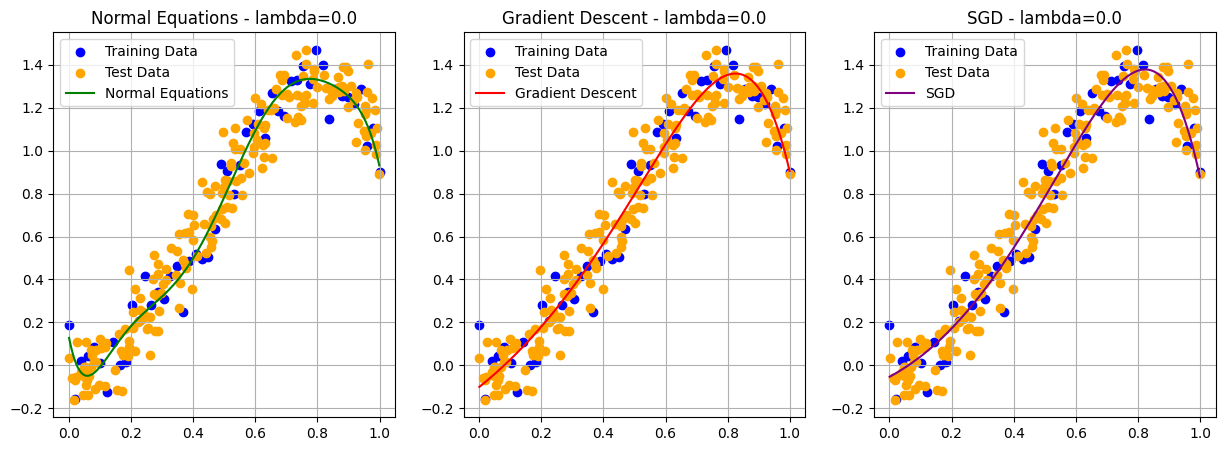

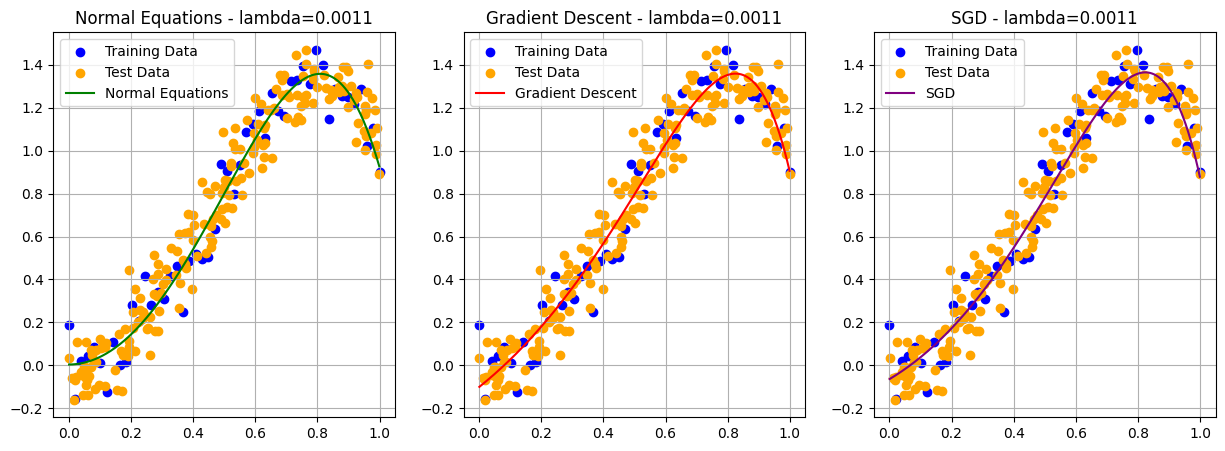

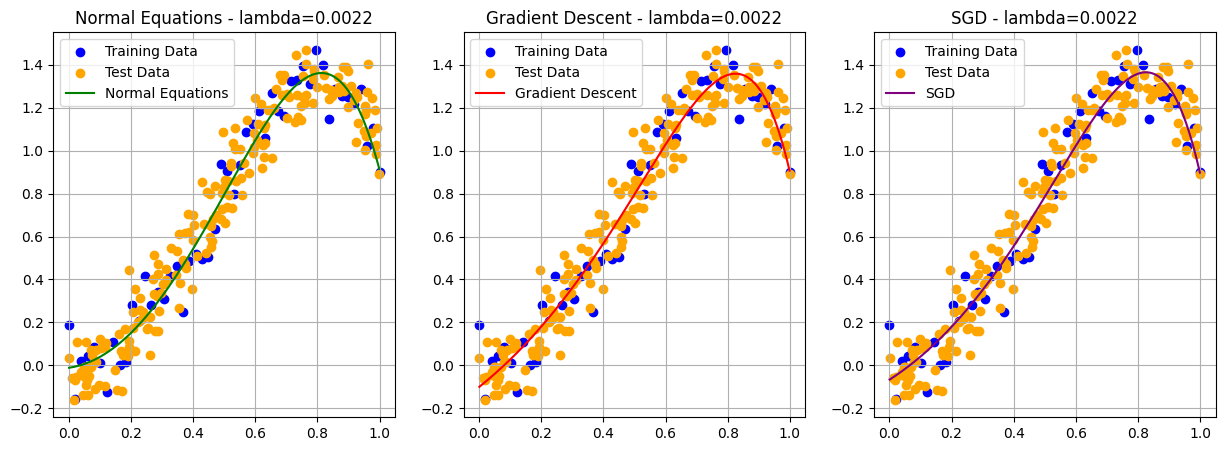

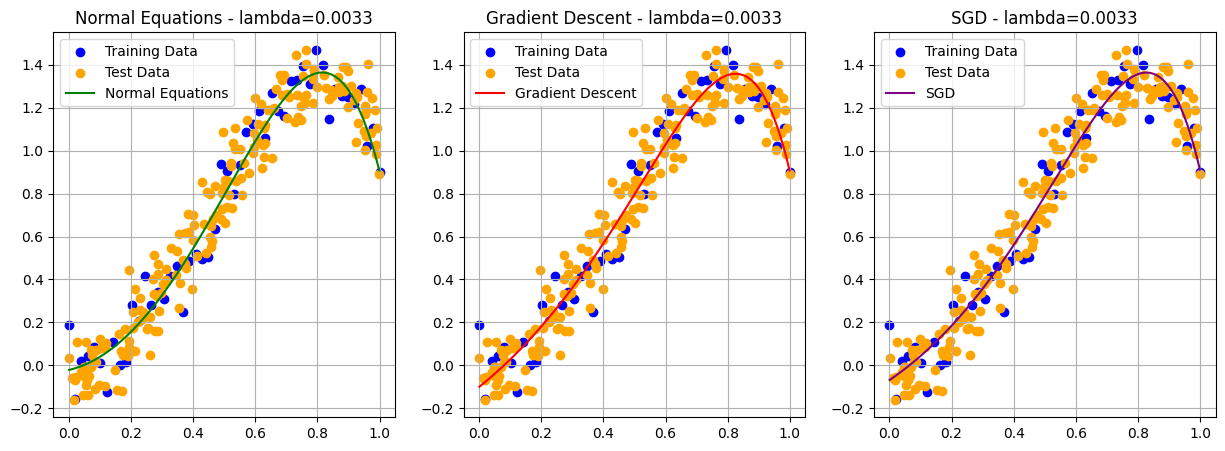

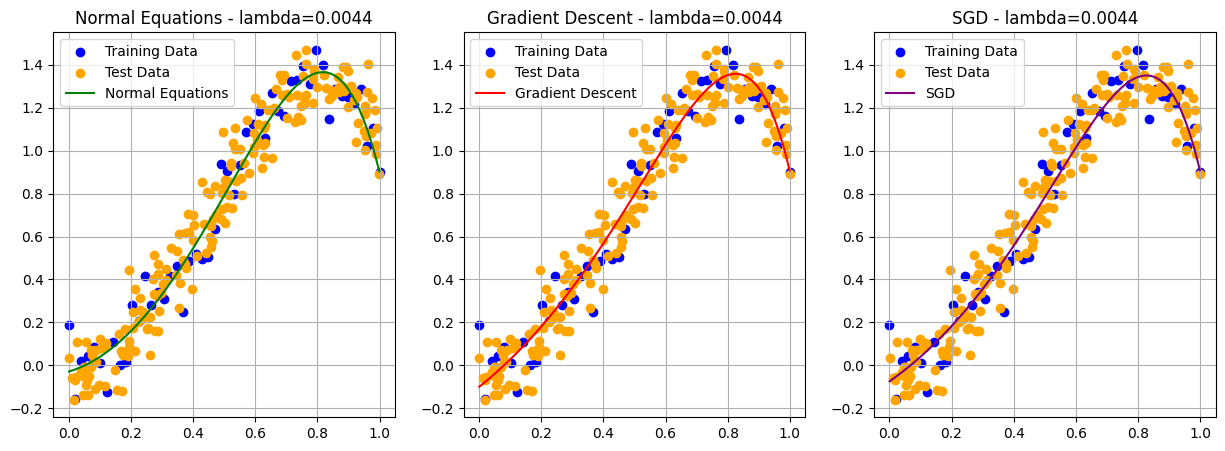

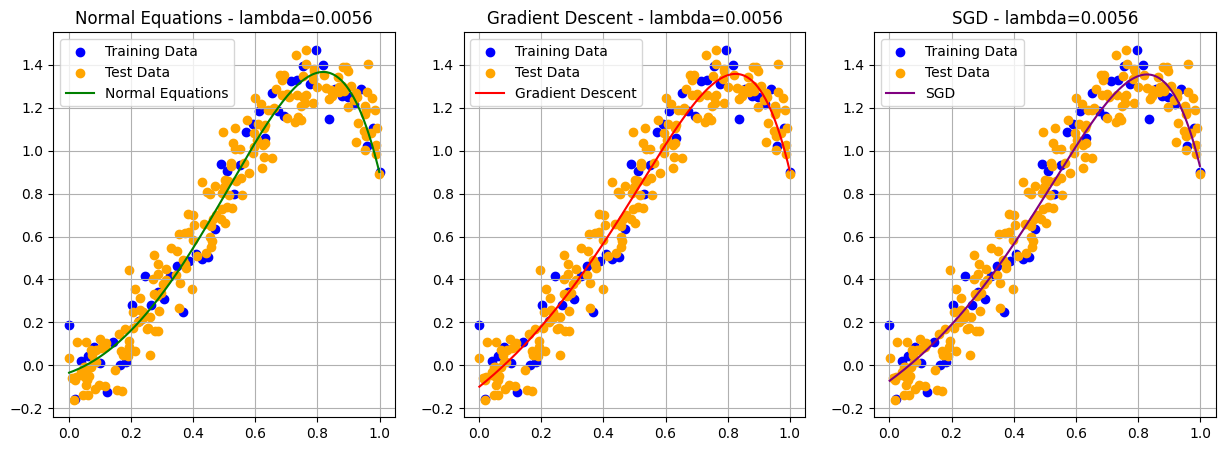

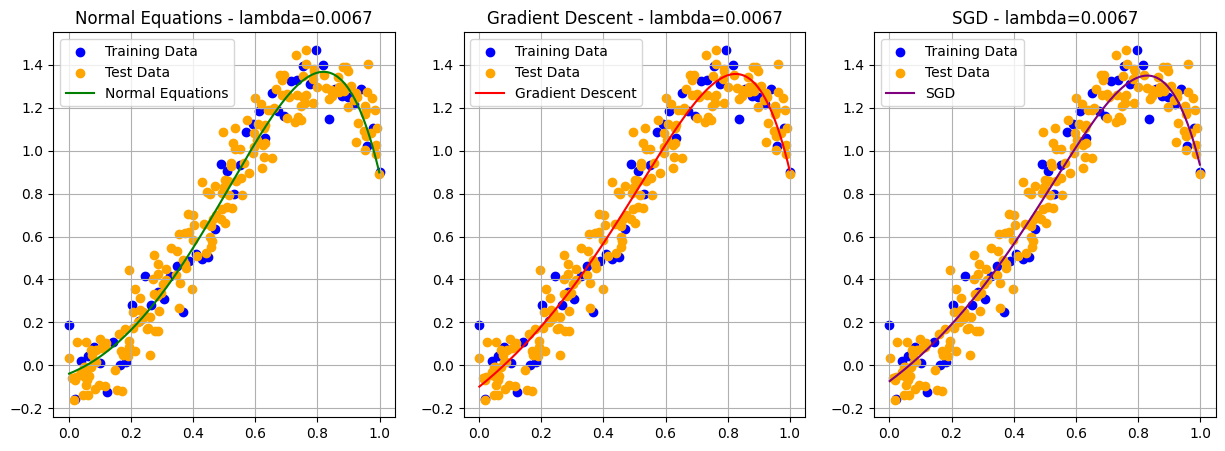

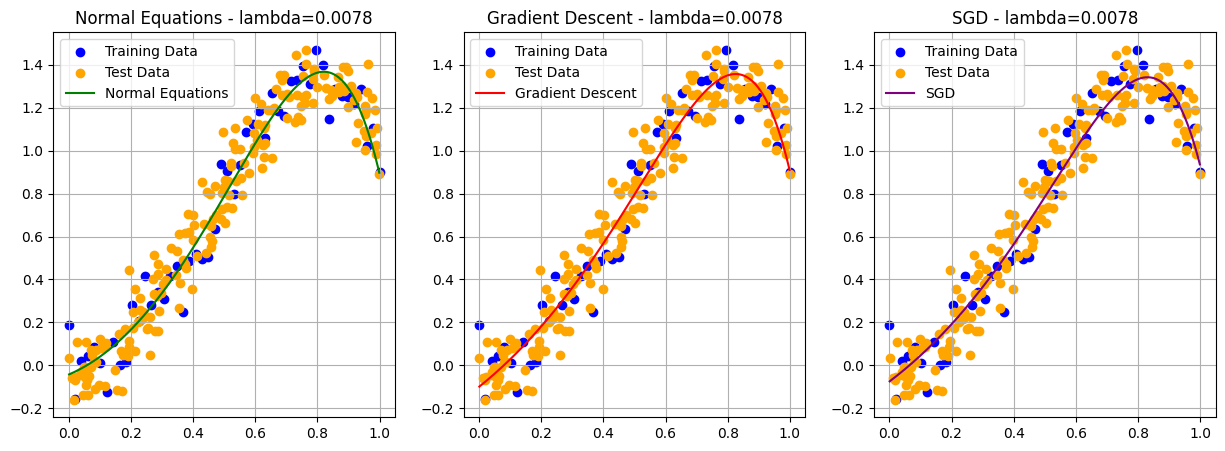

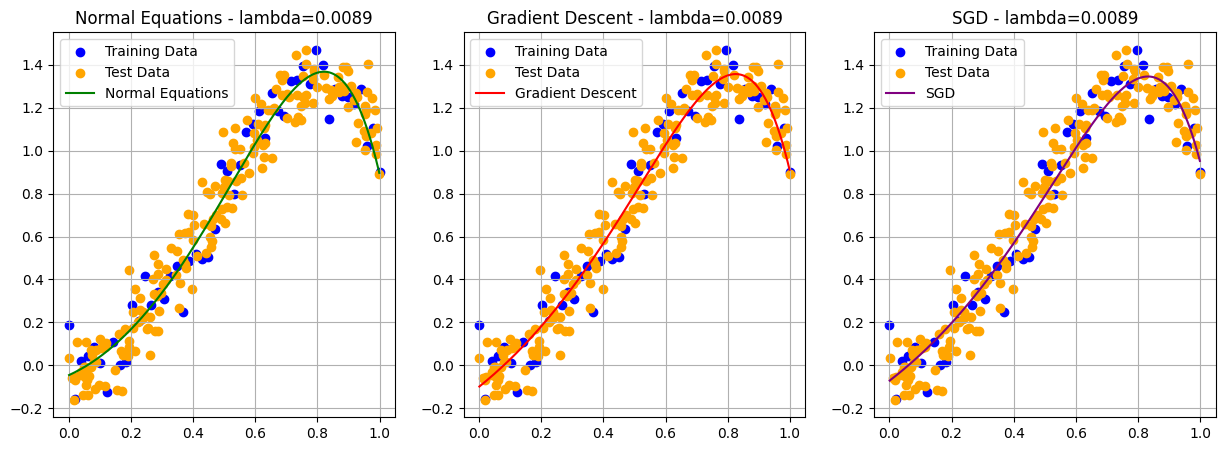

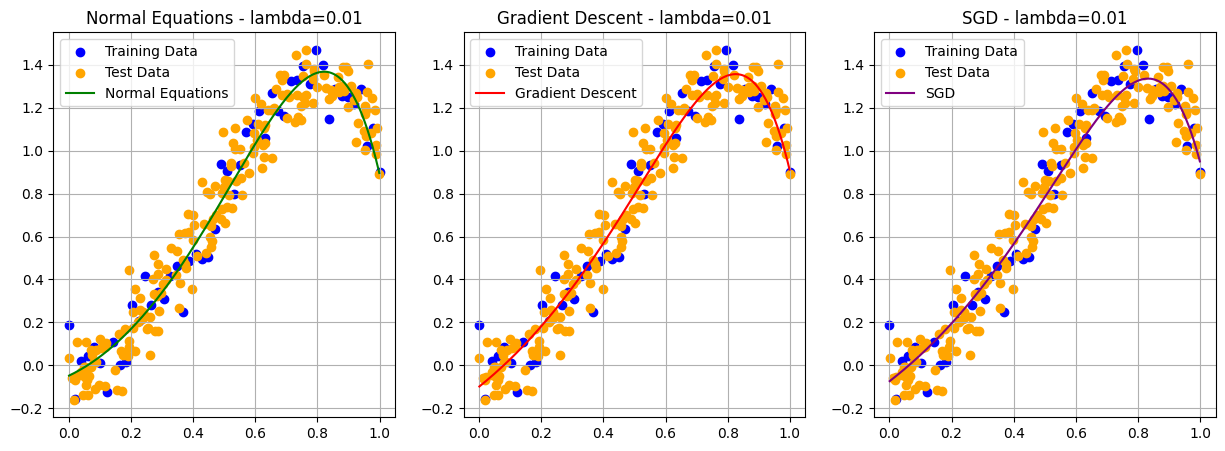

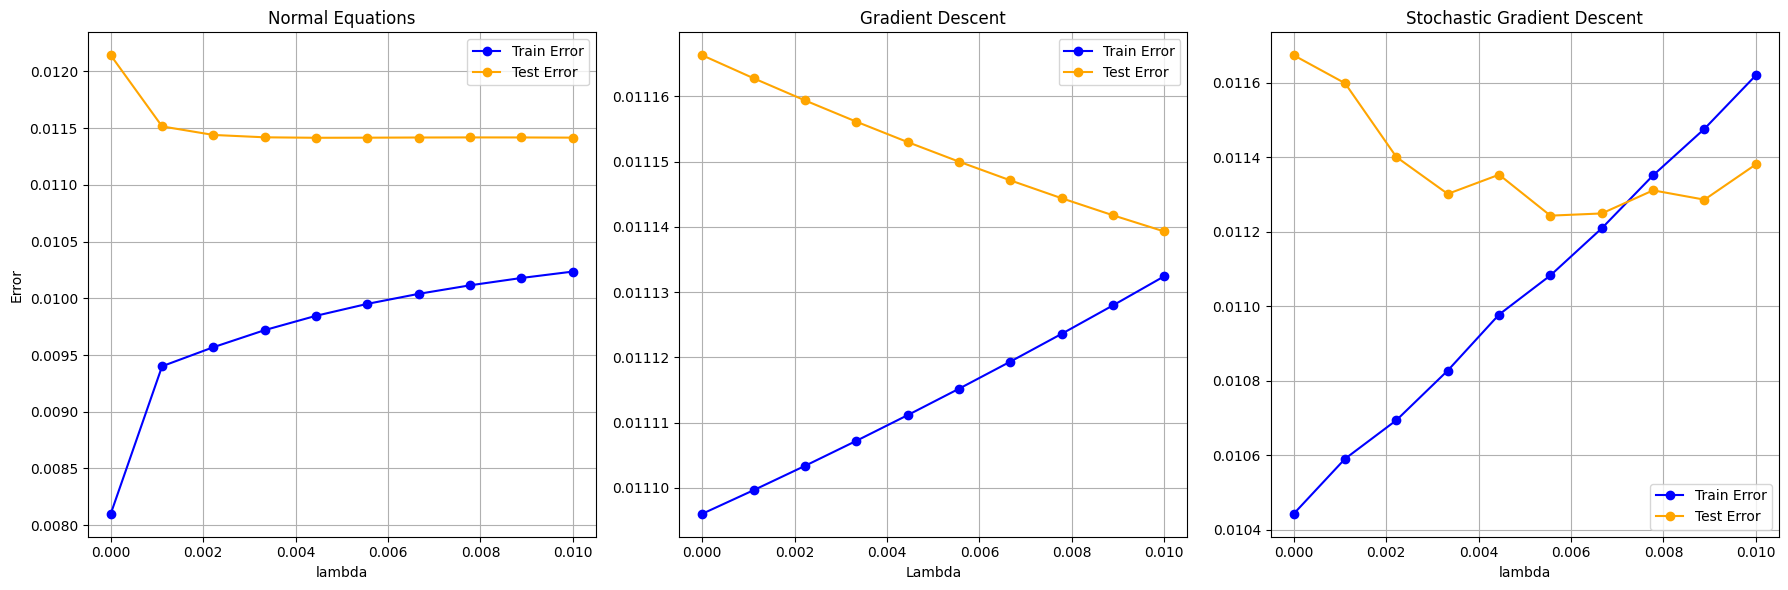

In [73]:
# Hyperparameters
train_errors_ne = []
test_errors_ne = []
train_errors_gd = []
test_errors_gd = []
train_errors_sgd = []
test_errors_sgd = []
lambdas=[]
thetas_gd_map=[]
thetas_sgd_map=[]
thetas_ne_map=[]
K=8

for lamb in np.linspace(0,10e-3,10):
  
    lambdas.append(lamb)
    # Normal Equations
    start_time = time.time()
    # Compute theta using NE
    theta_ne = NE_MAP(X_train, Y_train, K,lamb)
    time_ne = time.time() - start_time
    thetas_ne_map.append(theta_ne)
    train_error_ne = compute_error(theta_ne, (X_train, Y_train))
    test_error_ne = compute_error(theta_ne, (X_test, y_test))
    train_errors_ne.append(train_error_ne)
    test_errors_ne.append(test_error_ne)

    # Gradient Descent
    start_time = time.time()
    # Compute theta using GD
    theta_gd, loss_hist_gd, grad_norm_hist_gd = GD_MAP(X_train, Y_train, K, alpha_GD, maxit, tolf, tolx,lamb)
    time_gd = time.time() - start_time
    thetas_gd_map.append(theta_gd)
    train_error_gd = compute_error(theta_gd, (X_train, Y_train))
    test_error_gd = compute_error(theta_gd, (X_test, y_test))
    train_errors_gd.append(train_error_gd)
    test_errors_gd.append(test_error_gd)
    # Stochastic Gradient Descent
    start_time = time.time()
    # Compute theta using SGD
    theta_sgd, loss_hist_sgd, grad_norm_hist_sgd = SGD_MAP(X_train, Y_train, K, alpha_SGD, batch_size, n_epochs,lamb)
    time_sgd = time.time() - start_time
    thetas_sgd_map.append(theta_sgd)
    train_error_sgd = compute_error(theta_sgd, (X_train, Y_train))
    test_error_sgd = compute_error(theta_sgd, (X_test, y_test))
    train_errors_sgd.append(train_error_sgd)
    test_errors_sgd.append(test_error_sgd)

    x_range = np.linspace(min(X_test), max(X_test), 500)
    y_ne = f(theta_ne,x_range)
    y_gd = f( theta_gd,x_range)
    y_sgd = f( theta_sgd,x_range)

    # Create a figure with 3 subplots side by side for each K
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[0].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[0].plot(x_range, y_ne, label="Normal Equations", color="green")
    axes[0].set_title(f'Normal Equations - lambda={round(lamb,4)}')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[1].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[1].plot(x_range, y_gd, label="Gradient Descent", color="red")
    axes[1].set_title(f'Gradient Descent - lambda={round(lamb,4)}')
    axes[1].legend()
    axes[1].grid(True)

    axes[2].scatter(X_train, Y_train, label="Training Data", color="blue")
    axes[2].scatter(X_test, y_test, label="Test Data", color="orange")
    axes[2].plot(x_range, y_sgd, label="SGD", color="purple")
    axes[2].set_title(f'SGD - lambda={round(lamb,4)}')
    axes[2].legend()
    axes[2].grid(True)

# Plot training and test errors for each method in a single row of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Normal Equations
axes[0].plot(lambdas, train_errors_ne, label="Train Error", color="blue", marker="o")
axes[0].plot(lambdas, test_errors_ne, label="Test Error", color="orange", marker="o")
axes[0].set_title("Normal Equations")
axes[0].set_xlabel("lambda")
axes[0].set_ylabel("Error")
axes[0].legend()
axes[0].grid(True)

# Gradient Descent
axes[1].plot(lambdas, train_errors_gd, label="Train Error", color="blue", marker="o")
axes[1].plot(lambdas, test_errors_gd, label="Test Error", color="orange", marker="o")
axes[1].set_title("Gradient Descent")
axes[1].set_xlabel("Lambda")
axes[1].legend()
axes[1].grid(True)

# Stochastic Gradient Descent
axes[2].plot(lambdas, train_errors_sgd, label="Train Error", color="blue", marker="o")
axes[2].plot(lambdas, test_errors_sgd, label="Test Error", color="orange", marker="o")
axes[2].set_title("Stochastic Gradient Descent")
axes[2].set_xlabel("lambda")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


As we can see from the graphs above, using a little lambda help reduce the test error since the curves for all the three model stabilize lightly, so the overfitting gets lower.
Amplifying lambda can lead to overfitting causing performance to get worse.